In [ ]:
!python3 export.py --weights best.pt --grid --end2end --simplify --topk-all 100 --conf-thres 0.35 --img-size 320 320 --max-wh 320

In [4]:
import onnx
import onnxruntime as ort
import time
import cv2
import numpy as np
import random
from PIL import Image
import tensorflow as tf
import coremltools
import matplotlib.pyplot as plt

In [13]:
#check model
onnx_model = onnx.load("best.onnx")
onnx.checker.check_model(onnx_model)

In [14]:
#make session
so = ort.SessionOptions()
session = ort.InferenceSession('best.onnx')

In [53]:
#prepare the input
def letterbox(im, new_shape=(320, 320), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

names = ['Glasses', 'Sunglasses', 'Beer', 'Ball', 'Pen','Piano', 'Headphones', 'Light switch', 'Footwear', 'Watch', 'Coffeemaker', 'Waste container', 'Window', 'Window blind', 'Door handle', "Door", "Stairs", 'Bicycle','Car','Motorcycle','Bus','Train','Truck','Traffic light','Fire hydrant','Bench','Bird','Cat','Dog','Backpack','Handbag','Suitcase','Bottle','Wine glass','Coffee cup','Fork','Knife','Spoon','Bowl','Chair','Couch','Plant','Bed','Table','Toilet','Television','Laptop','Computer mouse','Remote control','Computer keyboard','Mobile phone','Microwave oven','Oven','Toaster','Sink','Refrigerator','Book','Clock','Toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

image=cv2.imread('inference/images/bus.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape

outname = [i.name for i in session.get_outputs()]
outname

inname = [i.name for i in session.get_inputs()]
inname

inp = {inname[0]:im}

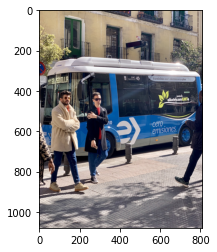

In [54]:
plt.imshow(img)

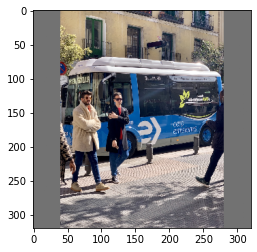

In [55]:
plt.imshow(np.moveaxis(im[0], 0,2))

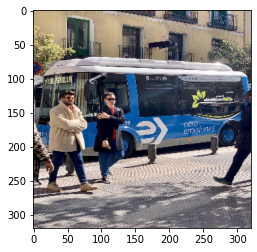

In [56]:
resized=cv2.resize(img, (320,320))
plt.imshow(resized)

In [60]:
image = resized.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape
inp = {inname[0]:im}

In [61]:
#time output
start=time.time()
outputs = session.run(outname, inp)[0]
end=time.time()
print(end-start)

0.1270763874053955


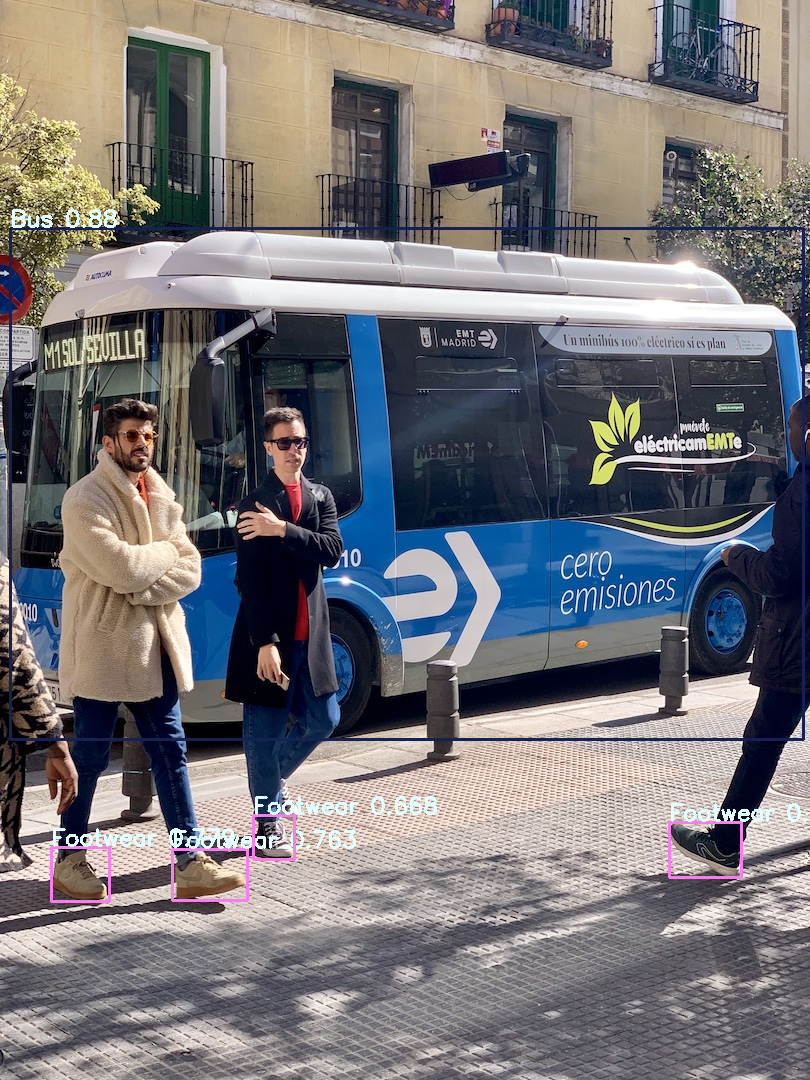

In [58]:
#check results
ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  

Image.fromarray(ori_images[0])

In [59]:
for output in outputs:
    print(output[6])

0.8804055
0.7788554
0.7626278
0.72687036
0.6681951


In [63]:
for output in outputs:
    print(output[6])

0.8966206
0.7612029
0.7424401
0.7049731
0.68877316
0.50339997
0.45727992


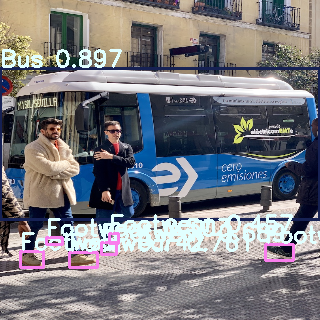

In [62]:
asd=np.moveaxis(im[0],0,2)
random_array = asd * 255
asd = random_array.astype(np.uint8)
ori_images = [asd.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    # box -= np.array(dwdh*2)
    # box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  

Image.fromarray(ori_images[0])

In [7]:
#convert to tf model

import onnx
from onnx_tf.backend import prepare
 
onnx_model = onnx.load("best.onnx")
tf_rep = prepare(onnx_model)
tf_rep.export_graph("best_tf2.pb")

INFO:tensorflow:Assets written to: best_tf2.pb/assets


INFO:tensorflow:Assets written to: best_tf2.pb/assets


In [10]:
#check tf model
model=tf.saved_model.load("best_tf2.pb")
infer = model.signatures["serving_default"]
print(infer.structured_outputs)

{'output': TensorSpec(shape=(None, 7), dtype=tf.float32, name='output')}


In [14]:
#time tf model
start=time.time()
labeling = infer(tf.constant(im))['output']
end=time.time()
print(end-start)
print("Result after saving and loading:\n", labeling)

0.28922605514526367
Result after saving and loading:
 tf.Tensor(
[[  0.          42.837563    67.4346     277.86148    219.09842
   20.           0.8804054 ]
 [  0.          55.24254    250.90295     72.20637    267.0719
    8.           0.77885556]
 [  0.          90.87985    251.59859    113.26341    266.54825
    8.           0.7626281 ]
 [  0.         238.10217    243.6067     259.4587     259.83276
    8.           0.7268706 ]
 [  0.         114.8876     241.45859    127.095505   254.44907
    8.           0.6681948 ]], shape=(5, 7), dtype=float32)


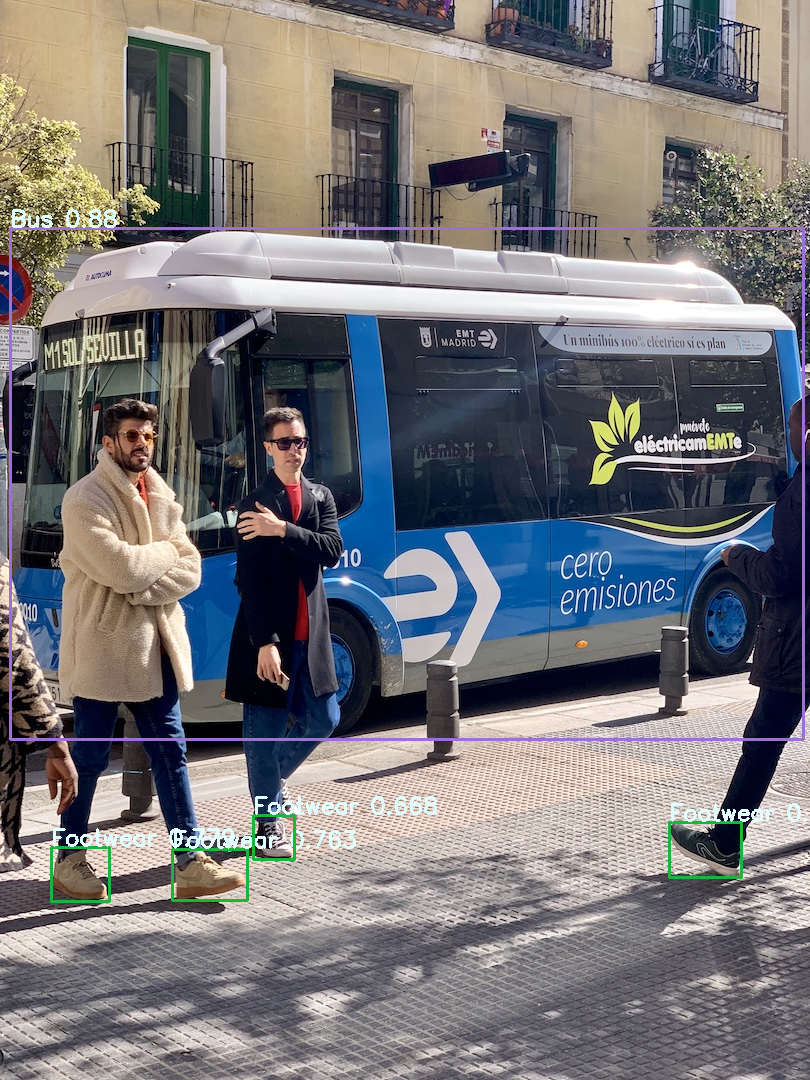

In [15]:
#check the output
ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(labeling):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  

Image.fromarray(ori_images[0])

In [16]:
#import yolov5 stuff
import sys
sys.path.insert(1, '../yolov5')

from utils.dataloaders import LoadImages
from utils.general import (LOGGER, check_dataset, check_img_size, check_requirements, check_version, check_yaml,
                           colorstr, file_size, print_args, url2file)
from utils.augmentations import Albumentations, augment_hsv, copy_paste, letterbox, mixup, random_perspective

/home/ubuntu/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
#need representative dataset for quantization
def representative_dataset_gen(dataset, ncalib=100):
    # Representative dataset generator for use with converter.representative_dataset, returns a generator of np arrays
    for n, (path, img, im0s, vid_cap, string) in enumerate(dataset):
        # im = np.transpose(img, [1, 2, 0])
        im=img
        im = np.expand_dims(im, axis=0).astype(np.float32)
        im /= 255
        yield [im]
        if n >= ncalib:
            break

In [23]:
input_nodes = tf_rep.inputs
output_nodes = tf_rep.outputs

In [27]:
#tflite, quantization and nms
#working code!
import tensorflow as tf
# from models.tf import representative_dataset_gen
imgsz=320
data='data/coco-Copy1.yaml'
# concrete_func = model.signatures[
#   tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
# concrete_func.inputs[0].set_shape([None, 3, 320, 320])
# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter = tf.lite.TFLiteConverter.from_saved_model("best_tf2.pb")
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.target_spec.supported_types = [tf.float16]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# dataset = LoadImages(check_dataset(check_yaml(data))['train'], img_size=imgsz, auto=False)
# converter.representative_dataset = lambda: representative_dataset_gen(dataset, ncalib=100)
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.target_spec.supported_types = []
# converter.inference_input_type = tf.uint8  # or tf.int8
# converter.inference_output_type = tf.uint8  # or tf.int8
# converter.experimental_new_quantizer = True
converter.target_spec.supported_ops.append(tf.lite.OpsSet.SELECT_TF_OPS)
tflite_model = converter.convert()
open('best-tflite3.tflite', "wb").write(tflite_model)

ValueError: Failed to parse the model: Only models with a single subgraph are supported, model had 9 subgraphs.

In [ ]:
#tflite model try
tflite_model='best-tflite3.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model)
interpreter.allocate_tensors()


In [ ]:
# image=cv2.imread('bus.jpg')
# img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = img.copy()
# image, ratio, dwdh = letterbox(image, auto=False)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], im)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Inference output is {}".format(output_data))

In [28]:
import random
from PIL import Image
ori_images = [img.copy()]
names = ['Glasses', 'Sunglasses', 'Beer', 'Ball', 'Pen','Piano', 'Headphones', 'Light switch', 'Footwear', 'Watch', 'Coffeemaker', 'Waste container', 'Window', 'Window blind', 'Door handle', "Door", "Stairs", 'Bicycle','Car','Motorcycle','Bus','Train','Truck','Traffic light','Fire hydrant','Bench','Bird','Cat','Dog','Backpack','Handbag','Suitcase','Bottle','Wine glass','Coffee cup','Fork','Knife','Spoon','Bowl','Chair','Couch','Plant','Bed','Table','Toilet','Television','Laptop','Computer mouse','Remote control','Computer keyboard','Mobile phone','Microwave oven','Oven','Toaster','Sink','Refrigerator','Book','Clock','Toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}
for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(output_data):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  
Image.fromarray(ori_images[0])

ValueError: Did not get operators or tensors in subgraph 2.


In [ ]:
#int8 model
import tensorflow as tf
# from models.tf import representative_dataset_gen
imgsz=320
data='data/coco-Copy1.yaml'
# concrete_func = model.signatures[
#   tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
# concrete_func.inputs[0].set_shape([None, 3, 320, 320])
# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter = tf.lite.TFLiteConverter.from_saved_model("best_tf2.pb")
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.target_spec.supported_types = [tf.float16]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# dataset = LoadImages(check_dataset(check_yaml(data))['train'], img_size=imgsz, auto=False)
converter.representative_dataset = lambda: representative_dataset_gen(im[0])
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = []
converter.inference_input_type = tf.int8  # or tf.int8
# converter.inference_output_type = tf.int8  # or tf.int8
converter.experimental_new_quantizer = True
converter.target_spec.supported_ops.append(tf.lite.OpsSet.SELECT_TF_OPS)
tflite_model = converter.convert()
open('best-tflite-int8-2.tflite', "wb").write(tflite_model)

In [ ]:
image=cv2.imread('image3.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)
im = image.astype(np.float32)
im =im/255
im = image.astype(np.int8)

im.shape